<a href="https://colab.research.google.com/github/sayannath/Image-Scene-Classification/blob/master/Scene_Detection_MobileNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Gathering

In [1]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Initial Setup

In [1]:
!nvidia-smi

Mon Mar  1 09:42:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |      0MiB / 16160MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.4.1


In [17]:
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import re 

import numpy as np
np.random.seed(42)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Data Parsing

In [4]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
image_paths[:5]

['training/8_Beach/10.jpg',
 'training/7_Food/390.jpg',
 'training/21_Night_shot/264.jpg',
 'training/17_Cloudy_Sky/209.jpg',
 'training/20_Flower/273.jpg']

In [5]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count) 

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '22_Stage_concert': 322,
         '16_Blue_Sky': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


In [6]:
TRAIN_SPLIT = 0.9
IMG_SIZE = 224
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
EPOCHS = 100

In [7]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


In [8]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[28 27 12  7 11]


## Data Loader Utilities

In [9]:
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    # No rescaling since MobileNetV3 internally does it
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))
val_ds = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Since the dataset has class imbalance issue, it's good to supply class weights while training the model. 

In [11]:
# Reference: https://www.pyimagesearch.com/2019/02/18/breast-cancer-classification-with-keras-and-deep-learning/
trainLabels = to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Model Building and Training

In [12]:
def get_training_model(trainable=False):
    # Load the MobileNetV3 model but exclude the classification layers
    EXTRACTOR = MobileNetV3Small(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(30, activation="softmax", dtype="float32")(class_head)

    # Create the new model
    classifier = tf.keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [13]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

In [14]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

Epoch 1/100
35/35 [==============================] - 42s 856ms/step - loss: 3.7951 - accuracy: 0.3546 - val_loss: 0.4982 - val_accuracy: 0.8616
Epoch 2/100
35/35 [==============================] - 36s 864ms/step - loss: 1.0425 - accuracy: 0.8027 - val_loss: 0.3514 - val_accuracy: 0.8960
Epoch 3/100
35/35 [==============================] - 36s 856ms/step - loss: 0.7896 - accuracy: 0.8375 - val_loss: 0.3116 - val_accuracy: 0.9040
Epoch 4/100
35/35 [==============================] - 37s 876ms/step - loss: 0.6610 - accuracy: 0.8685 - val_loss: 0.2894 - val_accuracy: 0.9061
Epoch 5/100
35/35 [==============================] - 36s 854ms/step - loss: 0.6056 - accuracy: 0.8793 - val_loss: 0.2628 - val_accuracy: 0.9141
Epoch 6/100
35/35 [==============================] - 36s 862ms/step - loss: 0.5526 - accuracy: 0.8860 - val_loss: 0.2606 - val_accuracy: 0.9202
Epoch 7/100
35/35 [==============================] - 36s 860ms/step - loss: 0.4865 - accuracy: 0.9011 - val_loss: 0.2380 - val_accuracy:

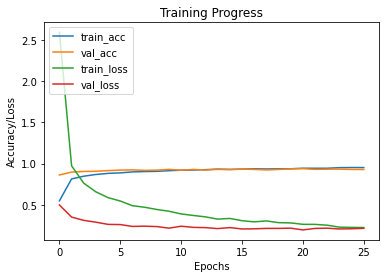

In [15]:
classifier = get_training_model()
h = classifier.fit(train_ds,
               validation_data=val_ds,
               epochs=EPOCHS,
               class_weight=classWeight,
               callbacks=train_callbacks)
accuracy = classifier.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(h)

In [16]:
# LR schedule
# Reference: https://t.ly/IT9G
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
train_callbacks.extend([lr_callback])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
35/35 [==============================] - 41s 889ms/step - loss: 0.2430 - accuracy: 0.9458 - val_loss: 0.1916 - val_accuracy: 0.9374
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
35/35 [==============================] - 36s 859ms/step - loss: 0.2227 - accuracy: 0.9542 - val_loss: 0.1943 - val_accuracy: 0.9333
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
35/35 [==============================] - 36s 869ms/step - loss: 0.2250 - accuracy: 0.9528 - val_loss: 0.1945 - val_accuracy: 0.9354
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
35/35 [==============================] - 36s 857ms/step - loss: 0.1889 - accuracy: 0.9606 - val_loss: 0.1952 - val_accuracy: 0.9354
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.

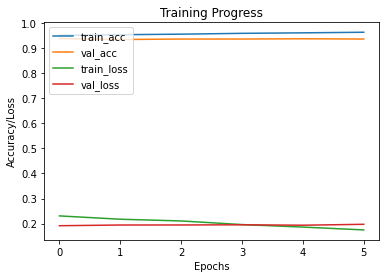

In [17]:
for layer in classifier.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
classifier.compile(loss="sparse_categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"])
h = classifier.fit(train_ds,
               validation_data=val_ds,
               epochs=EPOCHS,
               class_weight=classWeight,
               callbacks=train_callbacks)
accuracy = classifier.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(h)

## Serialize Main Model

In [18]:
classifier.save("mobilenet_v3_mai")

INFO:tensorflow:Assets written to: mobilenet_v3_mai/assets


In [19]:
!du -lh mobilenet_v3_mai

4.0K	mobilenet_v3_mai/assets
18M	mobilenet_v3_mai/variables
21M	mobilenet_v3_mai


## Inference Pipeline

In [10]:
!wget -q https://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_validation.zip
!unzip -qq camera_scene_detection_validation.zip

In [14]:
# https://stackoverflow.com/a/2669120/7636462
def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    # No rescaling since MobileNetV3 internally does it
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

In [15]:
test_image_paths = sorted_nicely(list(paths.list_images("images")))
print(f"Total test images: {len(test_image_paths)}")

Total test images: 600


In [16]:
test_image_paths[:5]

['images/0.jpg',
 'images/1.jpg',
 'images/2.jpg',
 'images/3.jpg',
 'images/4.jpg']

In [28]:
classifier_model = load_model("mobilenet_v3_mai")

test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = (
    test_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

test_predictions = np.argmax(classifier_model.predict(test_ds), 1)
test_predictions = le.inverse_transform(test_predictions)
print(test_predictions.shape)

(600,)


In [29]:
test_predictions_num = list(map(lambda x: x.split("_")[0], test_predictions.tolist()))
print(test_predictions_num[:5])
with open('results.txt', "w") as myfile:
    myfile.write('\n'.join(list(test_predictions_num)))
!head -5 results.txt

['9', '21', '27', '4', '28']
9
21
27
4
28
